In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import pymc3 as pm
import bambi as bmb
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error as MAPE

WARN: Could not locate executable g77
WARN: Could not locate executable f77
WARN: Could not locate executable ifort
WARN: Could not locate executable ifl
WARN: Could not locate executable f90
WARN: Could not locate executable DF
WARN: Could not locate executable efl
WARN: Could not locate executable gfortran
WARN: Could not locate executable f95
WARN: Could not locate executable g95
WARN: Could not locate executable efort
WARN: Could not locate executable efc
WARN: Could not locate executable flang
WARN: don't know how to compile Fortran code on platform 'nt'


WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Data collection
Данные взяты из https://www.kaggle.com/c/house-prices-advanced-regression-techniques

SalePrice - таргет

Обрабатывать тестовую выборку не станем, так как там нет таргета - не сможем провериться

In [2]:
cwd = os.getcwd()
TRAIN_FILE_NAME = "train.csv"
TEST_FILE_NAME = "test.csv"

df_train_raw = pd.read_csv(os.path.join(cwd, TRAIN_FILE_NAME)).drop(['Id'], axis=1)
#df_test_raw = pd.read_csv(os.path.join(cwd, TEST_FILE_NAME)).drop(['Id'], axis=1) # отсутствует таргет SalePrice
# df_train_raw

# EDA
## Data preparation for ML 

In [3]:
MISSING_BOUNDARY = 0.7

df_train = df_train_raw.copy()
# Выбросим признаки, в котрых число пропусков > 1 - MISSING_BOUNDARY 
cols_to_drop = []
df_train = df_train[[col for col in df_train if df_train[col].count() / len(df_train) >= MISSING_BOUNDARY]]
for col in df_train_raw.columns:
    if col not in df_train.columns:
        cols_to_drop.append(col)
             
# Энкодим категориальные признаки
enc = OrdinalEncoder(encoded_missing_value=-1, handle_unknown='use_encoded_value', unknown_value=np.nan)
df_train_cat = pd.DataFrame(
    data=enc.fit_transform(df_train.select_dtypes(include = ['O'])),
    columns=df_train.select_dtypes(include = ['O']).columns)

df_train = pd.concat([df_train.select_dtypes(include = ['float64', 'int64']), 
                      df_train_cat], axis=1)

# Заполняем пропуски
imp = KNNImputer(missing_values=np.nan)
df_train_p1 = pd.DataFrame(data=imp.fit_transform(df_train.drop(["SalePrice"], axis=1)),
                        columns=df_train.drop(["SalePrice"], axis=1).columns)

# standart scaler
scale = StandardScaler()
df_train_p1 = pd.DataFrame(data=scale.fit_transform(df_train_p1),
                        columns=df_train_p1.columns)

# scale target 
# scale_tg = StandardScaler()
# df_train["SalePrice"] = pd.DataFrame(data=scale_tg.fit_transform(df_train["SalePrice"].values.reshape(-1, 1)),
#                         columns=df_train[["SalePrice"]].columns)

df_train = pd.concat([df_train_p1, df_train["SalePrice"]], axis=1)


print("Число нулей после обработки: ", df_train.isnull().sum().sum())
print("Колонки, которые убрали: ", cols_to_drop)




# # Обработаем тестовую выборку также как трейн
# df_test = df_test_raw.drop(cols_to_drop, axis=1)
# df_test_cat = pd.DataFrame(
#     data=enc.transform(df_test.select_dtypes(include = ['O'])),
#     columns=df_test.select_dtypes(include = ['O']).columns)

# df_test = pd.concat([df_test.select_dtypes(include = ['float64', 'int64']), 
#                       df_test_cat], axis=1)

# df_test = pd.DataFrame(data=imp.transform(df_test),
#                         columns=df_test.columns)

# df_test = pd.DataFrame(data=scale.transform(df_test),
#                         columns=df_test.columns)

Число нулей после обработки:  0
Колонки, которые убрали:  ['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']


In [9]:
# уменьшим число точек, для более быстрого расчета
df_train = df_train.sample(frac=0.25, random_state=1)

C:\Users\oleg\AppData\Local\Temp\ipykernel_22800\3763950520.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_train['SalePrice'], color='g', bins=100, hist_kws={'alpha': 0.4});


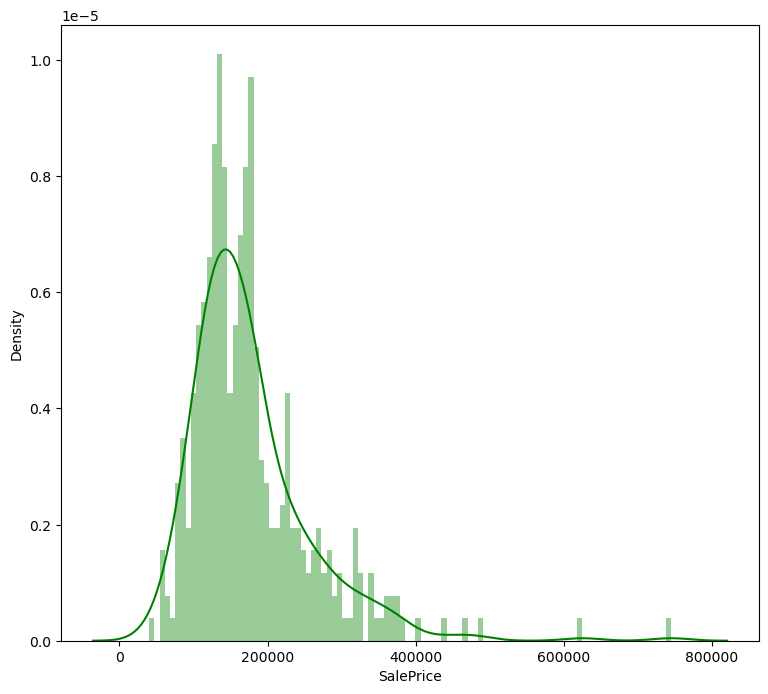

In [10]:
plt.figure(figsize=(9, 8))
sns.distplot(df_train['SalePrice'], color='g', bins=100, hist_kws={'alpha': 0.4});

# ML
Для Байесовского расчета регрессии будем использовать библиотеку bambi (https://github.com/bambinos/bambi/blob/main/docs/notebooks/ESCS_multiple_regression.ipynb), так как в официальом гайде от pymc3 (https://www.pymc.io/projects/docs/en/v3/pymc-examples/examples/generalized_linear_models/GLM-linear.html) дается ссылка на нее для более удобного использования в случае multivariate regression (independent predictors, https://vincentk1991.github.io/Bayesian-regression-tutorial/) 

In [11]:
# Уменьшим число признаков, для увеличения скорости расчета
features = list(df_train.columns)[:30]
tg = list(df_train.columns)[-1]

In [12]:
' + '.join(features)

'MSSubClass + LotFrontage + LotArea + OverallQual + OverallCond + YearBuilt + YearRemodAdd + MasVnrArea + BsmtFinSF1 + BsmtFinSF2 + BsmtUnfSF + TotalBsmtSF + 1stFlrSF + 2ndFlrSF + LowQualFinSF + GrLivArea + BsmtFullBath + BsmtHalfBath + FullBath + HalfBath + BedroomAbvGr + KitchenAbvGr + TotRmsAbvGrd + Fireplaces + GarageYrBlt + GarageCars + GarageArea + WoodDeckSF + OpenPorchSF + EnclosedPorch'

In [15]:
model = bmb.Model("SalePrice ~ MSSubClass + LotFrontage + LotArea + OverallQual + OverallCond + YearBuilt + YearRemodAdd + MasVnrArea + BsmtFinSF1 + BsmtFinSF2 + BsmtUnfSF + TotalBsmtSF + 1stFlrSF + 2ndFlrSF + LowQualFinSF + GrLivArea + BsmtFullBath + BsmtHalfBath + FullBath + HalfBath + BedroomAbvGr + KitchenAbvGr + TotRmsAbvGrd + Fireplaces + GarageYrBlt + GarageCars + GarageArea + WoodDeckSF + OpenPorchSF + EnclosedPorch",
                  df_train)
fitted = model.fit(tune=20, draws=20, init="adapt_diag", random_seed=1)


Only 20 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [SalePrice_sigma, Intercept, MSSubClass, LotFrontage, LotArea, OverallQual, OverallCond, YearBuilt, YearRemodAdd, MasVnrArea, BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF]


Sampling 4 chains for 20 tune and 20 draw iterations (80 + 80 draws total) took 310 seconds.
The number of samples is too small to check convergence reliably.


Sampling: [BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, Intercept, LotArea, LotFrontage, MSSubClass, MasVnrArea, OverallCond, OverallQual, SalePrice_sigma, TotalBsmtSF, YearBuilt, YearRemodAdd]


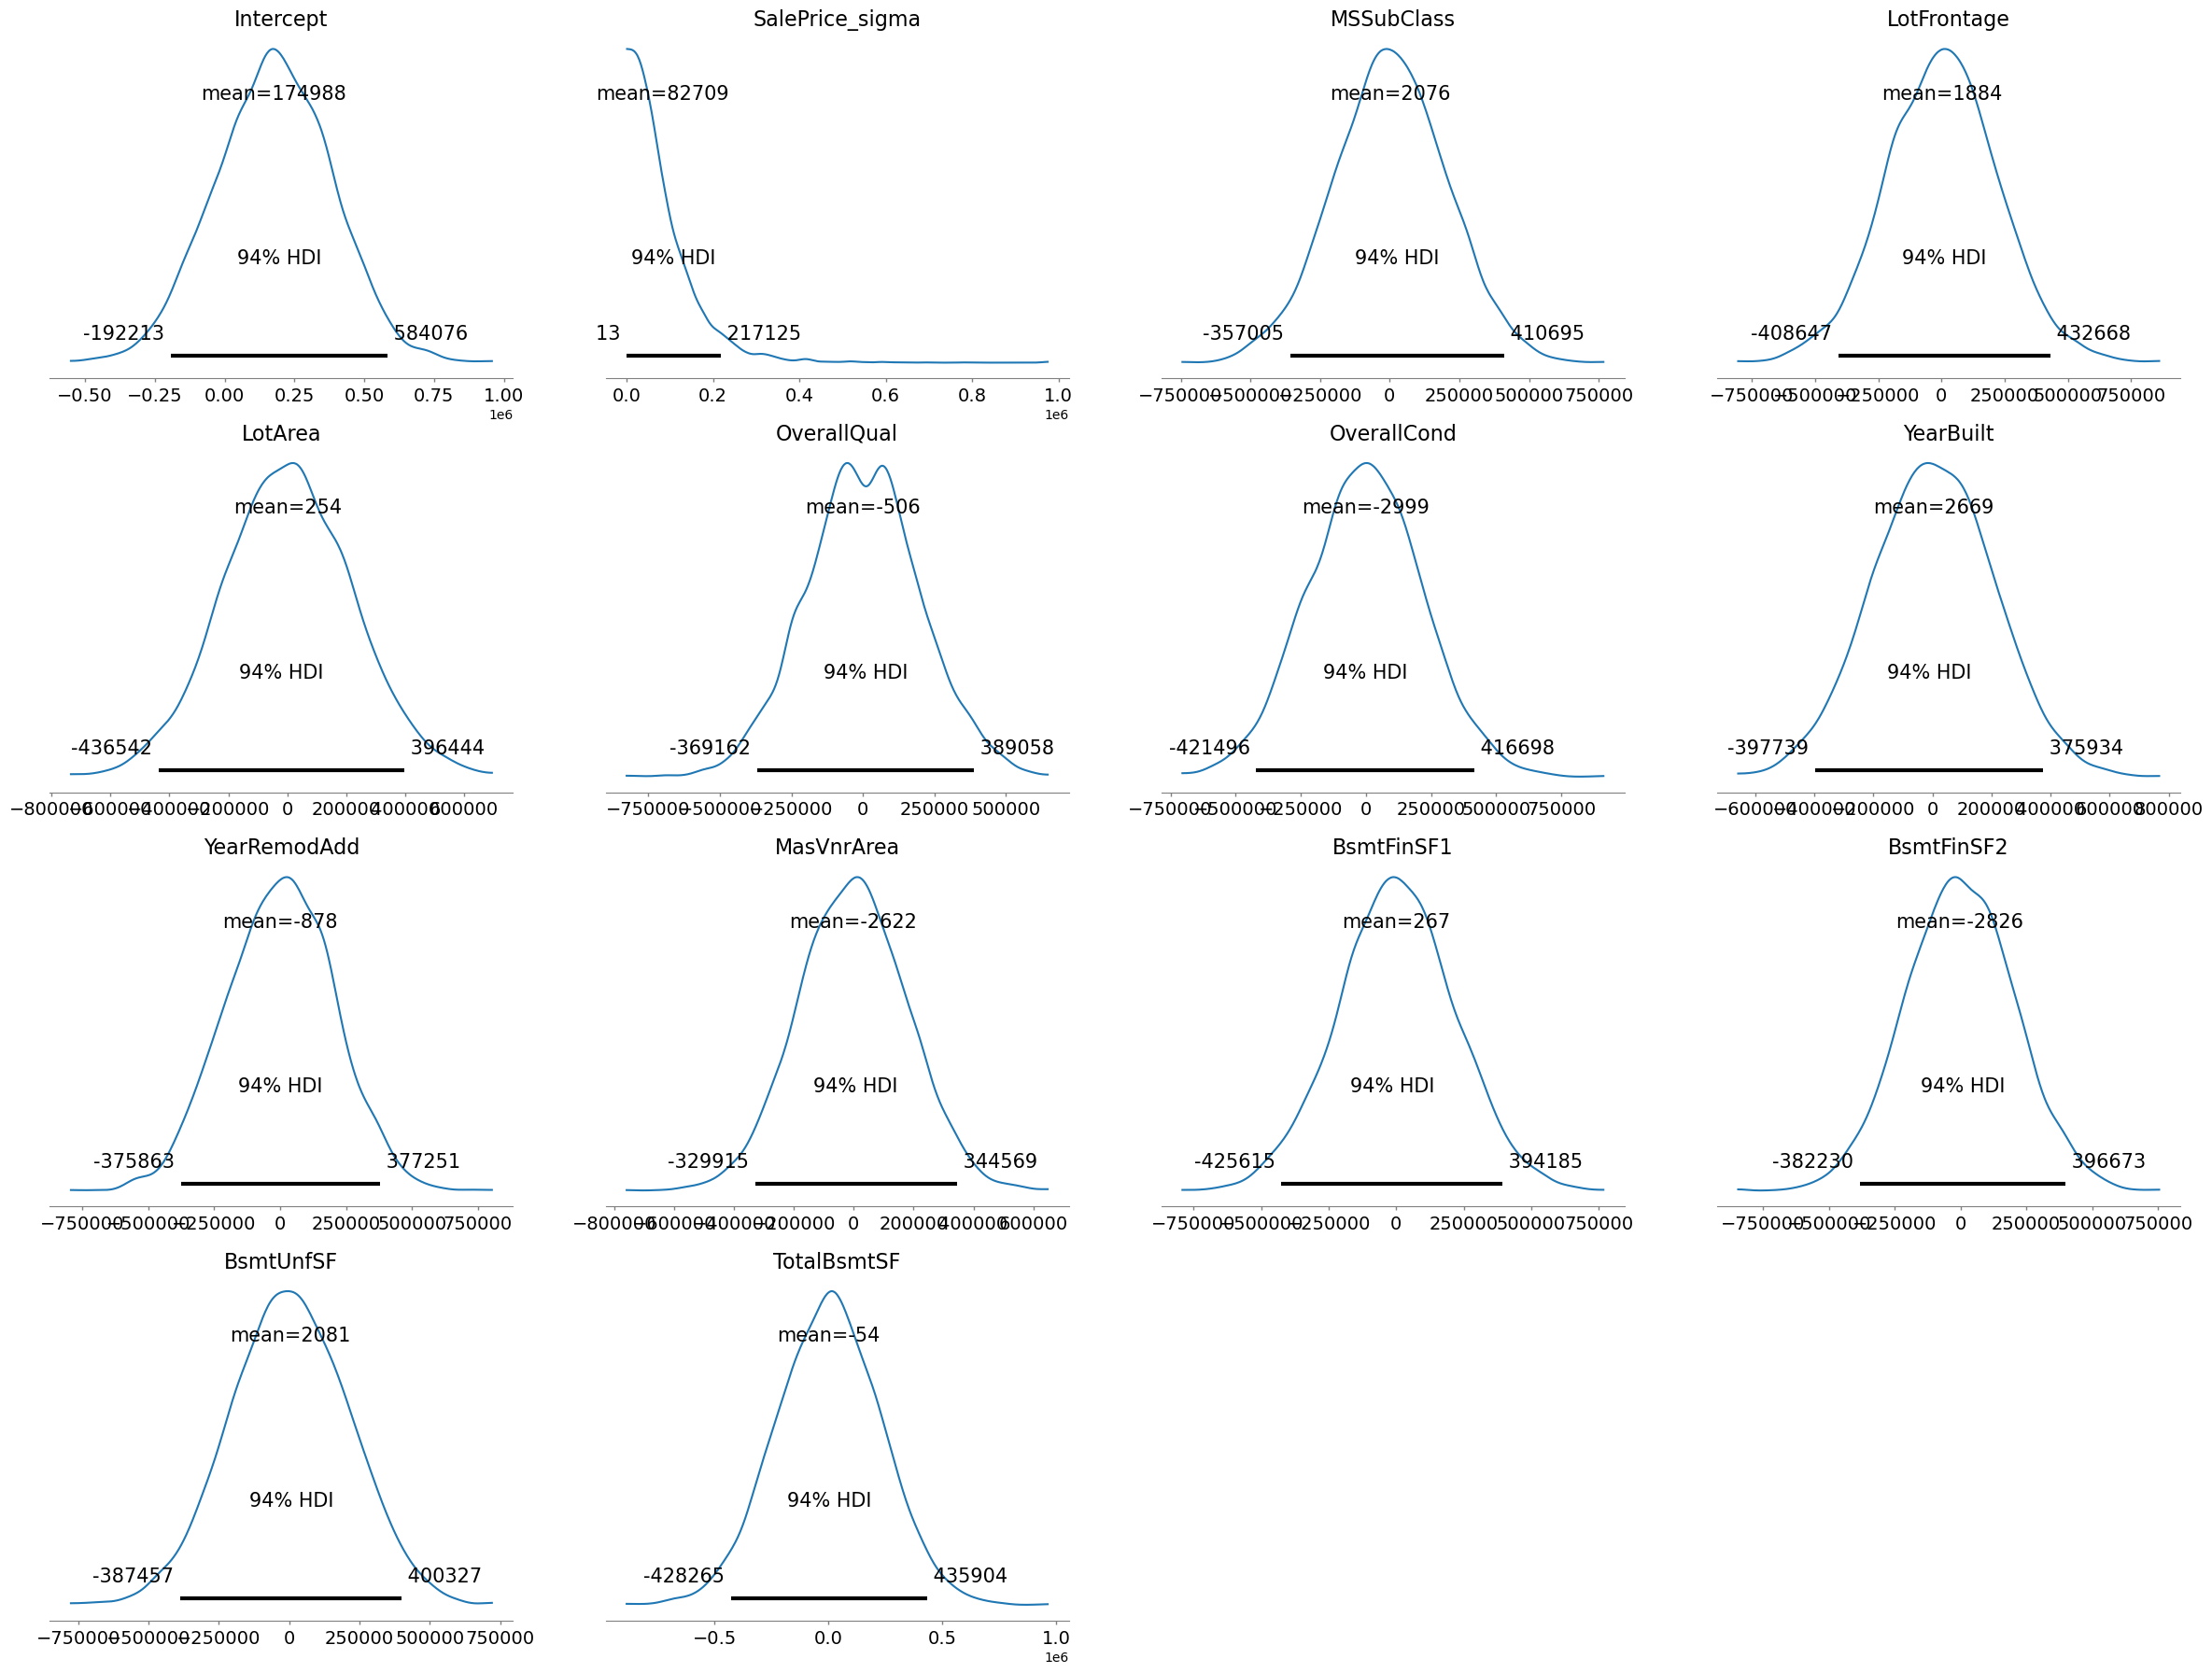

In [16]:
model.plot_priors();

In [45]:
# Normal priors on the coefficients
keys = [x.name for x in model.response_component.terms.values() if x.name not in ['Intercept', 'SalePrice']]

{x.name: x.prior.args for x in model.response_component.terms.values()}

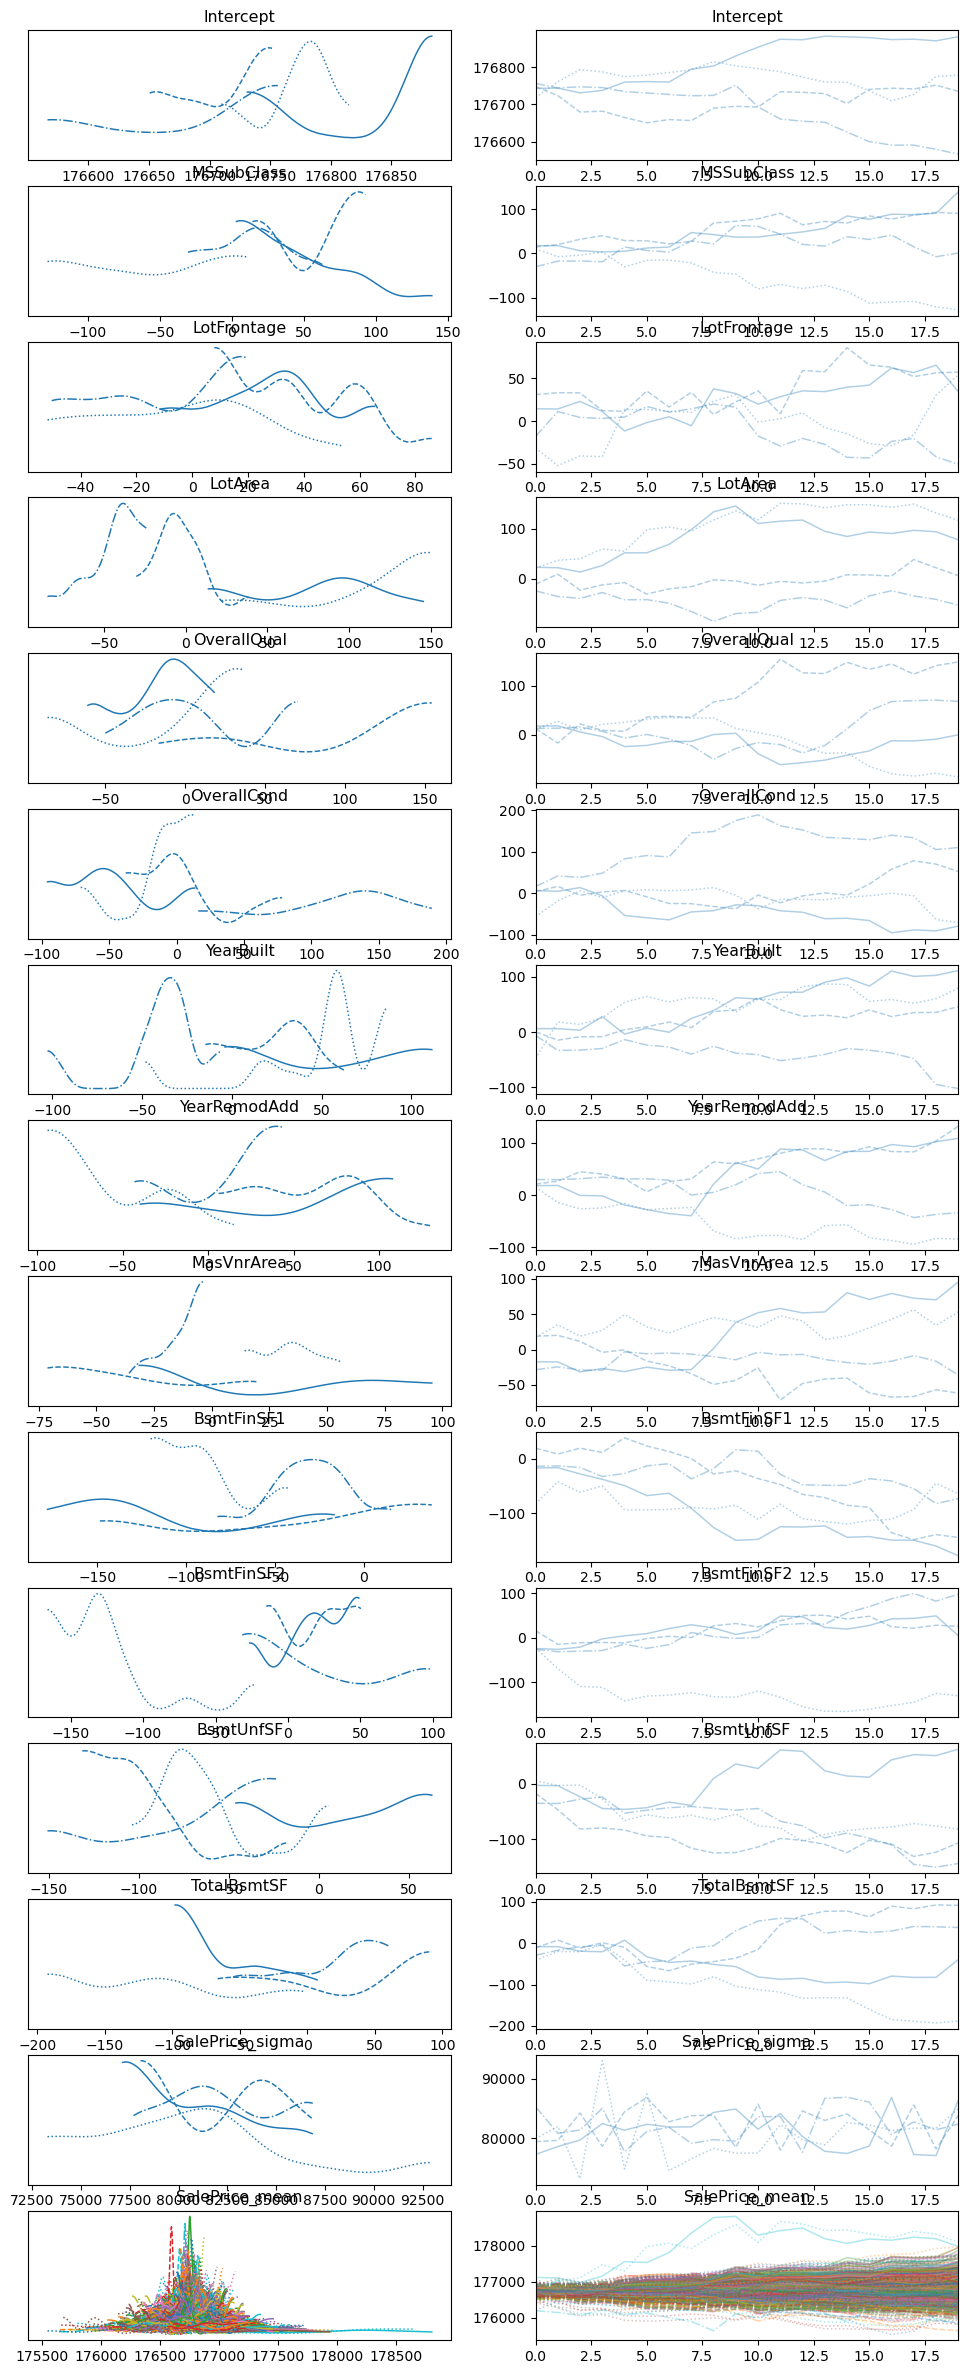

In [39]:
az.plot_trace(fitted);

In [40]:
az.summary(fitted)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,176744.638,74.108,176599.824,176883.420,27.134,19.991,8.0,16.0,2.40
MSSubClass,15.917,56.733,-110.285,92.625,20.713,15.257,8.0,17.0,2.33
LotFrontage,12.859,31.413,-42.330,65.614,10.047,7.327,10.0,43.0,1.69
LotArea,35.117,69.207,-57.717,150.702,25.440,18.749,8.0,20.0,2.63
OverallQual,15.286,58.160,-64.172,154.261,20.682,15.774,9.0,16.0,1.87
...,...,...,...,...,...,...,...,...,...
SalePrice_mean[360],176709.653,165.266,176366.896,176996.638,58.560,43.028,8.0,18.0,2.17
SalePrice_mean[361],176870.364,219.681,176449.026,177206.736,80.306,59.158,8.0,16.0,2.65
SalePrice_mean[362],176765.735,103.738,176549.486,176935.853,30.673,22.268,12.0,20.0,1.45
SalePrice_mean[363],176663.744,462.219,175775.558,177332.042,172.106,126.988,8.0,18.0,2.89


In [41]:
posterior_predictive = model.predict(fitted, kind="pps")
fitted

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

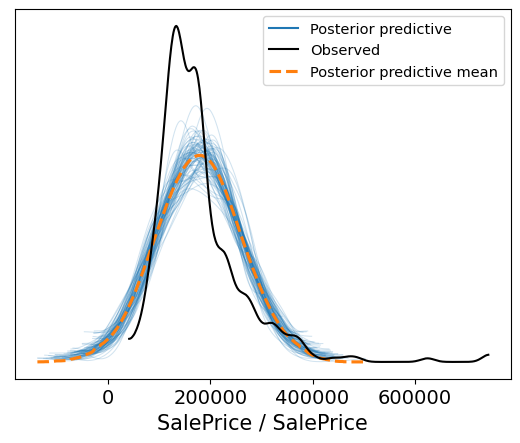

In [42]:
az.plot_ppc(fitted);

In [53]:
# В качестве оценки параметров Байесовским методом, возмем средние зачения оценки коэффициентов 
k = az.summary(fitted)["mean"].loc[keys]
b = az.summary(fitted)["mean"].loc["Intercept"]

y_pred = (k * df_train[keys]).sum(axis=1, numeric_only=True) + b

MAPE(y_pred, df_train[tg])

0.32535302256695586

# Заключение

1) Байесовский метод работает медленнее чем классическое машинное обучение, но ему нужно меньше данных для большей точности

2) Полученная погрешность может быть улушена, за счет использования всех признаков и всех данных, а не семпла. Также, можно увеличить число tune и draws шагов